# Exploring genetic variant consequences

This analysis aimed to examine the distribution of genetic variants broadly classified by their broader consequences within a gene region using data retrieved from [Ensembl's Variant Effect Predictor API](https://rest.ensembl.org/#VEP).

To achieve this, the following steps were performed:

1. Consequence Data Retrieval and Preparation: Genetic variant consequence data was obtained from the Ensembl Variant Effect Predictor API. This data underwent processing and preparation for analysis according to procedures outlined in the `Notebooks\Data_preparation\5-Variant_consequences.ipynb `Jupyter notebook. The processed data is stored in the `Data\Processed\Variant_consequences.csv` file.


2. Data Filtering: To ensure that the variant data represented only Recent African population groups, information on African American and African Caribbean subpopulations was excluded.
3. Variant Classification: Variants were grouped and counted based on specific consequence categories. Similarly, the number of variants classified as deleterious or neutral were tallied.
4. Visualisation: To offer insights into the distribution of variant consequences and effects for each gene, separate stacked barplots were generated for visualisation.

## Import libraries and modules

In [2]:
# Change working directory

import os
os.chdir(r"C:\Users\User\Desktop\Megan\MSC2\Results\5._Posthoc_analysis\Pipeline_GnomAD_14032023\Notebooks")

In [3]:
# Import modules and packages

import os
import numpy as np
import pandas as pd
import seaborn as sns
import upsetplot
from matplotlib import pyplot as plt

import sys

sys.path.append(
    r"C:\Users\User\Desktop\Megan\MSC2\Results\5._Posthoc_analysis\Pipeline_GnomAD_14032023"
)
import Utils.constants as constants
import Utils.functions as functions


## Set plot parameters

In [4]:
sns.set(rc={"figure.figsize": (10, 8)})

plt.rc("font", size=constants.MEDIUM_FONT)  # controls default text sizes
plt.rc("axes", titlesize=constants.MEDIUM_FONT)  # fontsize of the axes title
plt.rc("axes", labelsize=constants.BIGGER_FONT)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("legend", fontsize=constants.SMALL_FONT)  # legend fontsize
plt.rc("figure", titlesize=constants.BIGGER_FONT)  # fontsize of the figure title

## Import data

In [6]:
# Import variant effect data

consequence_data = pd.read_csv(
    os.path.join(
        constants.HOME_PATH,
        "Data",
        "Processed",
        "Variant_consequences.csv",
    )
).drop(columns="Unnamed: 0")

consequence_data.head(5)

,ID,POS,REF,ALT,CONSEQUENCE,GENE,CONSEQUENCE_CLASSIFICATION
0,chr13:110148882C-CT,110148882,C,CT,downstream_gene_variant,COL4A1,downstream
1,rs552586867,110148891,C,G,downstream_gene_variant,COL4A1,downstream
2,rs59409892,110148917,C,G,downstream_gene_variant,COL4A1,downstream
3,rs535182970,110148920,G,C,downstream_gene_variant,COL4A1,downstream
4,rs56406633,110148959,A,G,downstream_gene_variant,COL4A1,downstream


## Data filtering
To ensure that the variant data represented only Recent African population groups, information on African American and African Caribbean subpopulations was excluded.


In [9]:
# Import genetic variant data for African populations

ih_afr = pd.read_csv(
    os.path.join(
        constants.HOME_PATH,
        "Data",
        "Processed",
        "IH_allele_counts.csv",
    )
).drop(columns="Unnamed: 0")

# Ensure that variants with recent African alternate counts = 0 are removed as these variants are not present in the African population
ih_recent_afr = ih_afr[(ih_afr["REG"] == "Recent African") & ~(ih_afr["IH_ALT_CTS"] == 0)]

# Select consequence data for variants that are in Recent African populations
recent_african_consequence_data = ih_recent_afr.merge(consequence_data, how="left", left_on=["VAR_NAME", "REF", "ALT", "POS", "GENE"], right_on=["ID", "REF", "ALT", "POS", "GENE"]).drop(columns="ID_y").rename(columns={"ID_x":"ID"})

recent_african_consequence_data.head(5)

,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,IH_ALT_CTS,IH_TOTAL_CTS,ID,CORR_IH_TOTAL_CTS,CORR_IH_REF_CTS,CORR_IH_AF,REG,VARIANT_TYPE,CONSEQUENCE,CONSEQUENCE_CLASSIFICATION
0,rs552586867,110148891,C,G,COL4A1,NaN,2,1608,110148891_G_C,1608,1606,0.005714,Recent African,SNP,downstream_gene_variant,downstream
1,rs59409892,110148917,C,G,COL4A1,NaN,152,1608,110148917_G_C,1608,1456,1.106859,Recent African,SNP,downstream_gene_variant,downstream
2,rs546124548,110149176,T,A,COL4A1,NaN,1,1608,110149176_A_T,1608,1607,0.003378,Recent African,SNP,3_prime_UTR_variant,3-prime UTR
3,rs139916479,110149349,G,A,COL4A1,NaN,7,1608,110149349_A_G,1608,1601,0.081208,Recent African,SNP,3_prime_UTR_variant,3-prime UTR
4,rs552877576,110149494,C,T,COL4A1,NaN,2,1608,110149494_T_C,1608,1606,0.005682,Recent African,SNP,3_prime_UTR_variant,3-prime UTR


## Variant Classification
Variants were grouped by consequence and counted.

In [23]:
# Count variants by gene and consequence

recent_african_consequence_grouped = functions.group_and_count(
    recent_african_consequence_data, ["GENE", "CONSEQUENCE_CLASSIFICATION"]
).reset_index().rename(columns={"ID": "COUNT"})

# Pivot dataframe

recent_african_consequence_pivot = recent_african_consequence_grouped.pivot(
    index="GENE", columns="CONSEQUENCE_CLASSIFICATION", values="COUNT"
).replace(np.NAN, 0).reset_index()

recent_african_consequence_pivot.head(5)

CONSEQUENCE_CLASSIFICATION,GENE,3-prime UTR,5-prime UTR,downstream,exonic,intronic,splice donor,splice region,upstream
0,AGT,10.0,1.0,105.0,32.0,224.0,0.0,3.0,120.0
1,AP4B1,9.0,2.0,1.0,26.0,98.0,0.0,0.0,16.0
2,CARD8,83.0,6.0,179.0,37.0,1057.0,1.0,2.0,12.0
3,CAT,17.0,1.0,4.0,14.0,566.0,3.0,1.0,4.0
4,COL4A1,14.0,2.0,2.0,53.0,3944.0,4.0,11.0,2.0


In [24]:
# Add total variant count information. Use the total count information to calculate the number of variants without consequence classifications.

recent_african_gene_count_grouped = ih_recent_afr[["GENE", "ID"]].groupby("GENE").count().rename(columns={"ID":"TOTAL"})
recent_african_consequence_pivot = recent_african_consequence_pivot.merge(recent_african_gene_count_grouped, on="GENE").set_index("GENE").reset_index()

recent_african_consequence_pivot.head(5)

,GENE,3-prime UTR,5-prime UTR,downstream,exonic,intronic,splice donor,splice region,upstream,TOTAL
0,AGT,10.0,1.0,105.0,32.0,224.0,0.0,3.0,120.0,1271
1,AP4B1,9.0,2.0,1.0,26.0,98.0,0.0,0.0,16.0,153
2,CARD8,83.0,6.0,179.0,37.0,1057.0,1.0,2.0,12.0,2110
3,CAT,17.0,1.0,4.0,14.0,566.0,3.0,1.0,4.0,616
4,COL4A1,14.0,2.0,2.0,53.0,3944.0,4.0,11.0,2.0,4060


In [25]:
# Calculate the number of variants without classifications
recent_african_consequence_pivot["unclassified"] = recent_african_consequence_pivot.TOTAL - recent_african_consequence_pivot.iloc[:, :-1].sum(axis=1)

recent_african_consequence_pivot = recent_african_consequence_pivot.drop(columns="TOTAL")

recent_african_consequence_pivot.head(5)

C:\Users\User\AppData\Local\Temp\ipykernel_7996\619362354.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  recent_african_consequence_pivot["unclassified"] = recent_african_consequence_pivot.TOTAL - recent_african_consequence_pivot.iloc[:, :-1].sum(axis=1)


,GENE,3-prime UTR,5-prime UTR,downstream,exonic,intronic,splice donor,splice region,upstream,unclassified
0,AGT,10.0,1.0,105.0,32.0,224.0,0.0,3.0,120.0,776.0
1,AP4B1,9.0,2.0,1.0,26.0,98.0,0.0,0.0,16.0,1.0
2,CARD8,83.0,6.0,179.0,37.0,1057.0,1.0,2.0,12.0,733.0
3,CAT,17.0,1.0,4.0,14.0,566.0,3.0,1.0,4.0,6.0
4,COL4A1,14.0,2.0,2.0,53.0,3944.0,4.0,11.0,2.0,28.0


## Visualisation

##### Bar plot showing the distribution of variant consequences

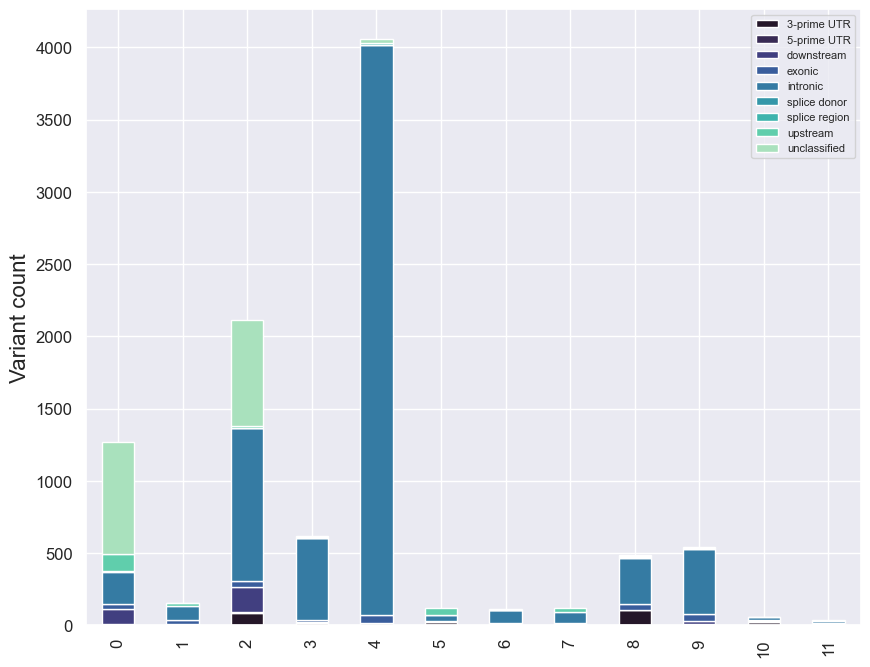

In [28]:
# Define a custom colour palette for plot
custom_palette = sns.color_palette("mako", 9)

# Construct barplot
consequence_plot = functions.create_plot(
    plot_type="stacked_barplot",
    palette=custom_palette,
    data=recent_african_consequence_pivot,
    xlabel=None,
    ylabel="Variant count",
    plot_title=None,
)
plt.savefig("..\Results\Figures\Variant_consequences.png", dpi=1200)
plt.show()